In [11]:
import wrds
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

db = wrds.Connection(wrds_username="djolitto")

#downloading the data 
data = db.raw_sql("select date, permco, ret, vol from crsp.dsf where permco in (7,35048, 8048, 21446, 20792) and date>='1999-12-31' and date<='2021-12-31'")



Loading library list...
Done


In [12]:
#firstly we can create an index so the Dataframe will be indexed with date
index = pd.DatetimeIndex(data.loc[data["permco"] == 20792]["date"].values)

#creating a new dataframe where for each column we have the simple return of each company
#for the column name we have used the ticket name
#first we create an empty dataframe and then we add columns
simple = pd.DataFrame(index = index)
simple["AAPL"] = data.loc[data["permco"] == 7]["ret"].values
simple["GS"] = data.loc[data["permco"] == 35048]["ret"].values
simple["MSFT"] = data.loc[data["permco"] == 8048]["ret"].values
simple["PG"] = data.loc[data["permco"] == 21446]["ret"].values
simple["GE"] = data.loc[data["permco"] == 20792]["ret"].values

#Question a 
mean = simple.mean()
variance = simple.var()
std = simple.std()

print(f"Mean of daily simple returns\n{simple.mean()}\n\nVariance of daily simple returns\n{simple.var()}")

Mean of daily simple returns
AAPL    0.001317
GS      0.000574
MSFT    0.000582
PG      0.000396
GE      0.000070
dtype: float64

Variance of daily simple returns
AAPL    0.000638
GS      0.000543
MSFT    0.000370
PG      0.000181
GE      0.000447
dtype: float64


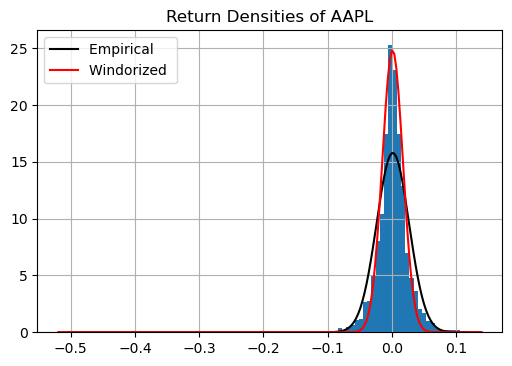

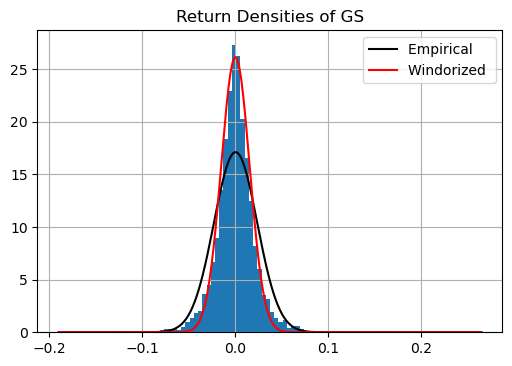

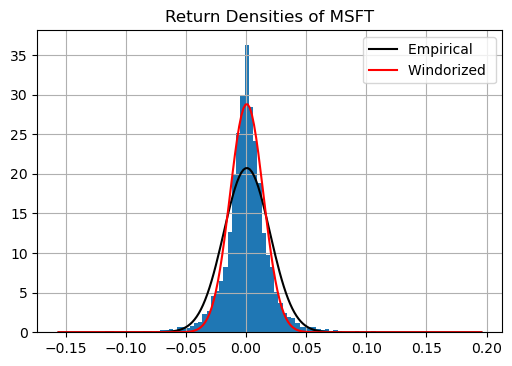

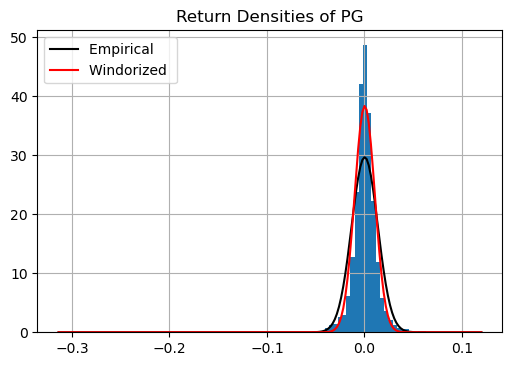

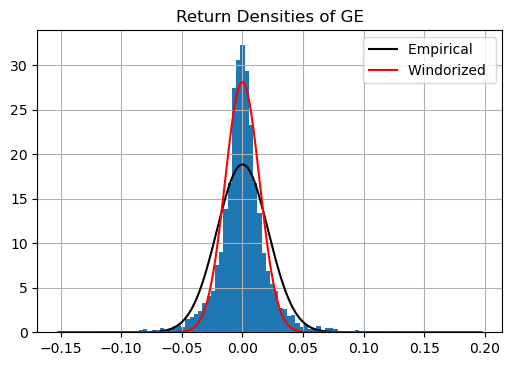

In [13]:
#Question b 
import matplotlib
import scipy
import scipy.stats 

#setting graphics parameter
matplotlib.rcParams["figure.dpi"] = 100


for i in simple.columns:
    #histogram 
    hist = simple[i].hist(bins=100, density=True)
    
    #empirical mean and std 
    sigma = simple[i].std()
    mu = simple[i].mean()
    
    #windosrized mean and std 
    mu_w, sigma_w = np.mean( simple[i][ abs(simple[i])<0.04 ]), np.std(simple[i][ abs(simple[i])<0.04 ])
    
    #plot densities
    x = np.linspace(np.min(simple[i]), np.max(simple[i]),200)
    
    normal = scipy.stats.norm.pdf( x, mu, sigma)
    normal_w  = scipy.stats.norm.pdf( x, mu_w, sigma_w)


    plt.plot(x ,normal, color = "black", label=  "Empirical ")
    plt.plot(x , normal_w, color = "red", label = "Windorized ")
    plt.legend()
    plt.title(f"Return Densities of {i}")
    plt.show()
    
    

In [4]:
#Question c
#empirical VaR: 
VaR_99 = simple.quantile(0.01)
VaR_95 = simple.quantile(0.05)
print(f"VaR at 95% level of the empirical distribution\n{VaR_95}\n")
print(f"VaR at 99% level of the empirical distribution\n{VaR_99}")

#empirical Expected Shortfall (ES):
print(f"\nExpected shortfall at 95% level of the empirical distribution\n{simple[simple < VaR_95].mean()}")
print(f"\nExpected shortfall at 99% level of the empirical distribution\n{simple[simple < VaR_99].mean()}")


#Normal distribution 
VaR_norm_95 = scipy.stats.norm.ppf(0.05, mean, std)
VaR_norm_99 =  scipy.stats.norm.ppf(0.01, mean,  std)

#normal VaR:
print(f"\nVaR at 95% level of the normal distribution")
for j,i in enumerate(simple.columns):
    print(f"{i}     {round(VaR_norm_95[j], 6)}")
    
print(f"\nVaR at 99% level of the normal distribution")
for j,i in enumerate(simple.columns):
    print(f"{i}     {round(VaR_norm_99[j], 6)}")

    
#Normal ES:
print(f"\nExpected Shortfall at 95% level of the normal distribution")
for j,i in enumerate(simple.columns): 
    print(f"{i}     {round((1/0.05) * scipy.stats.norm.expect(loc=simple.mean()[j], scale = simple.std()[j], ub= VaR_norm_95[j]),5)}")


print(f"\nExpected Shortfall at 99% level of the normal distribution")
for j,i in enumerate(simple.columns): 
    print(f"{i}     {round((1/0.01) * scipy.stats.norm.expect(loc=simple.mean()[j], scale = simple.std()[j], ub= VaR_norm_99[j]),5)}")


VaR at 95% level of the empirical distribution
AAPL   -0.036821
GS     -0.033491
MSFT   -0.028271
PG     -0.017501
GE     -0.031328
Name: 0.05, dtype: float64

VaR at 99% level of the empirical distribution
AAPL   -0.064024
GS     -0.062479
MSFT   -0.054251
PG     -0.035413
GE     -0.060500
Name: 0.01, dtype: float64

Expected shortfall at 95% level of the empirical distribution
AAPL   -0.056170
GS     -0.052027
MSFT   -0.044380
PG     -0.031212
GE     -0.049781
dtype: float64

Expected shortfall at 99% level of the empirical distribution
AAPL   -0.093438
GS     -0.090571
MSFT   -0.075562
PG     -0.057766
GE     -0.083368
dtype: float64

VaR at 95% level of the normal distribution
AAPL     -0.040232
GS     -0.037772
MSFT     -0.031054
PG     -0.021736
GE     -0.034696

VaR at 99% level of the normal distribution
AAPL     -0.057447
GS     -0.053659
MSFT     -0.044162
PG     -0.030906
GE     -0.0491

Expected Shortfall at 95% level of the normal distribution
AAPL     -0.05079
GS     -0.0

Question d 
We observe that the empirical distribution is a lot more fat tailed than the normal distribution. This means that "extreme" events occur more often.
The winsorized distribution is closer to the histogram of simple returns but is still less fat tailed than the histogram.
We can see this result also in the VaR and ES of the empirical distribution and the normal distribution. Both the VaR and ES are higher (in absolute terms) than the ones of the normal distribution.
We can conclude that the normal distribution describes the returns of the stocks very poorly and we should therefore not use it to model the stock returns, in fact the normal distribution does not describe the tails of the distribution of the stock's returns properly.



In [14]:
#Question e
#retrieving data of the two bonds 

bonds = db.raw_sql("select caldt, b2ret, b10ret from crsp.mcti where caldt>='1999-12-01' and caldt<='2021-12-31'", date_cols=["cals"])
bonds=bonds.set_index(bonds.caldt)
bonds = bonds.drop(columns="caldt")


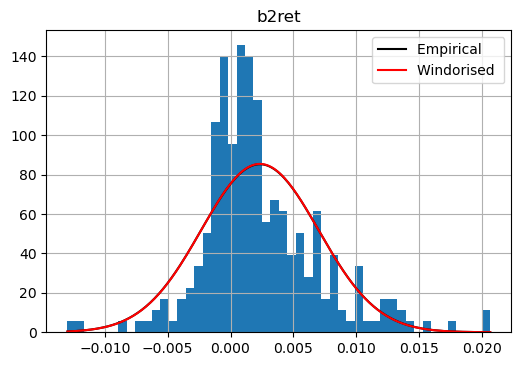

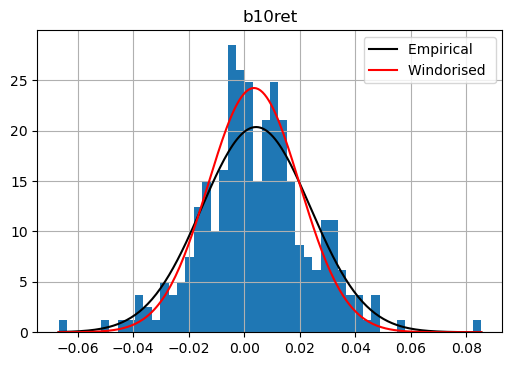

In [15]:

# we can reapply what we have done in point b 
for i in bonds.columns:
    #histogram 
    hist = bonds[i].hist(bins=50, density=True)
    #empirical mean and std 
    sigma = bonds[i].std()
    mu = bonds[i].mean()
    #windosrized mean and std 
    mu_w, sigma_w = np.mean( bonds[i][ abs(bonds[i])<0.04 ]), np.std(bonds[i][ abs(bonds[i])<0.04 ])
    
    #plot densities
    x = np.linspace(np.min(bonds[i]), np.max(bonds[i]),200)
    
    #normal density and normal winsorized 
    normal = scipy.stats.norm.pdf( x, mu, sigma)
    normal_w  = scipy.stats.norm.pdf( x, mu_w, sigma_w)
    
    plt.plot( x ,normal, color = "black", label=  "Empirical ")
    plt.plot(x , normal_w, color = "red", label = "Windorised ")
    plt.legend()
    plt.title(i)
    plt.show()


(e) cont'd:
We can see from the plot of the 2-year bond that the normal distribution and the winsorized normal distribution are (almost) identical and both describe the distribution of returns very poorly.
For the 10-year bond, however, the winsorized normal distributions describes the empirical distribution a lot better, although not perfectly. The normal distribution is, again, a poor description of the returns but not as bad as for the 2-year bond.
We can conclude that for long-term bonds, the (winsorized) normal distribution is a more or less good description of the returns. It is surely a better description of the returns than for the stocks. However, for the short-term bonds, they are also a bad measure.
We could think that this is due to the fact that extreme returns are more probably to happen in the stock market than in the bond market, and therefore the stock's returns distribution will have fatter tails than the bond distribution.




In [19]:
#EXERCISE 2
#Question a
#retrieving the data to use in the exercise and put them in a DataFrame 
df = db.raw_sql("select date, permco, ret, vol from crsp.dsf where permco in (7,21446) and date>='2010-01-01' and date<='2021-12-31'")

#firstly we can create an index so the Dataframe will be indexed with date
index = pd.DatetimeIndex(df.loc[df.permco == 7]["date"].values)

#creating a new dataframe where for each column we have the simple return of each company
#for the column name we have used the ticket name

data = pd.DataFrame(index = index)
data["AAPL"] = df.loc[df["permco"] == 7]["ret"].values
data["PG"] = df.loc[df["permco"] == 21446]["ret"].values

#we compute the risk free rate weekly
risk_free = (1.5/100) * (1/52)

#calculating weekly simple returns 
data = (data + 1).resample("W").prod() - 1

#expected weekly return 
expected_return = data.mean()

#expected weekly standard deviation 
expected_std = data.std()


print(f'Annualized expected return\n{expected_return*52}\n\nWeekly expected return\n{expected_return}')
print(f'\nAnnualized standard deviation\n{expected_std*np.sqrt(52)}\n\nWeekly standard deviation\n{expected_std}')
print('\nCorrelation:   ', cor)

Annualized expected return
AAPL    0.314888
PG      0.124941
dtype: float64

Weekly expected return
AAPL    0.006056
PG      0.002403
dtype: float64

Annualized standard deviation
AAPL    0.278855
PG      0.155484
dtype: float64

Weekly standard deviation
AAPL    0.038670
PG      0.021562
dtype: float64

Correlation:    0.17371646178054287


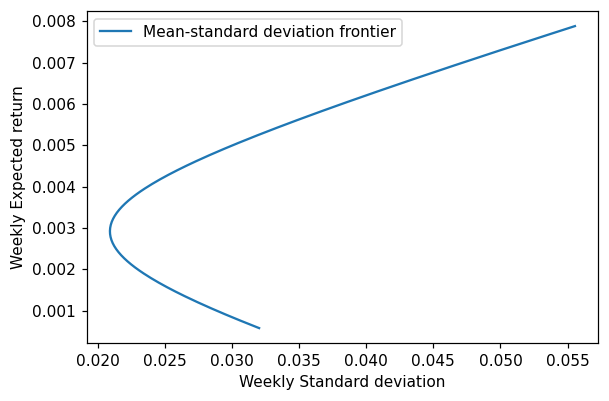

In [27]:
#Question b
matplotlib.rcParams["figure.dpi"] = 110

#correlation between the returns of the two stocks 
cor = np.correlate(data.AAPL, data.PG).item()
#covariance matrix
Sigma = np.cov(data["AAPL"], data["PG"])

#function that calculates the mean-standard deviation frontier that we can get combining the two assets
def frontier(mu, Sigma, w1):
    mean = mu[0]*w1 +(1-w1)*mu[1] 
    sigma = ( w1**2 * Sigma[0,0] + (1-w1)**2 * Sigma[1,1] + 2*w1*(1-w1)*Sigma[0,1] )**0.5
    return mean, sigma

#value of w
w = np.linspace(-0.5,1.5,200)
#we get the mean and the variance of each portfolio using the function defined before and 
#we plot all the combinations in the sigma, mu space
y, x = frontier(data.mean(), Sigma, w)
plt.plot(x,y, label="Mean-standard deviation frontier")
plt.legend()
plt.xlabel("Weekly Standard deviation")
plt.ylabel("Weekly Expected return")
plt.show()


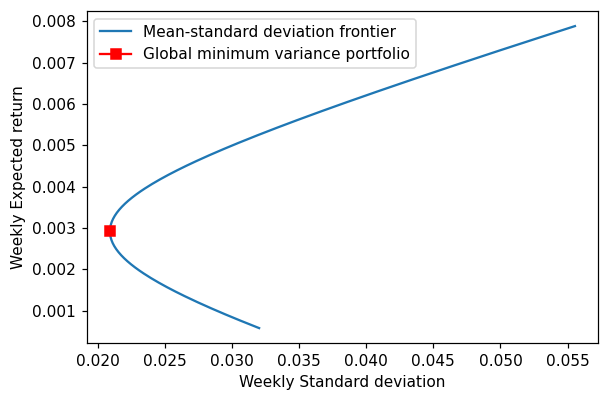


Minimum variance portfolio
Annualized expected mean: 0.15164
Annualized expected standard deviation: 0.15067
Annualized Sharpe Ratio: 0.9069024482036828


In [29]:
#Question c
#calculating the weight on the first asset of the portfolio of minimum variance using formula on the slide
w_min_var = (Sigma[1,1] - Sigma[0,1])/(Sigma[0,0]+Sigma[1,1]-2*Sigma[0,1])
#we got the mean and the variance of the minimum variance portfolio
y_min, x_min = frontier(data.mean(), Sigma, w_min_var)
#plot the results
plt.plot(x,y, label="Mean-standard deviation frontier")
plt.plot(x_min, y_min, color="red", marker="s", label="Global minimum variance portfolio")
plt.xlabel("Weekly Standard deviation")
plt.ylabel("Weekly Expected return")
plt.legend()
plt.show()

print("\nMinimum variance portfolio")
print(f"Annualized expected mean: {round(y_min*52,5)}\nAnnualized expected standard deviation: {round(x_min*np.sqrt(52),5)}\nAnnualized Sharpe Ratio: {(y_min - risk_free)*52/ (np.sqrt(52)*x_min) }")


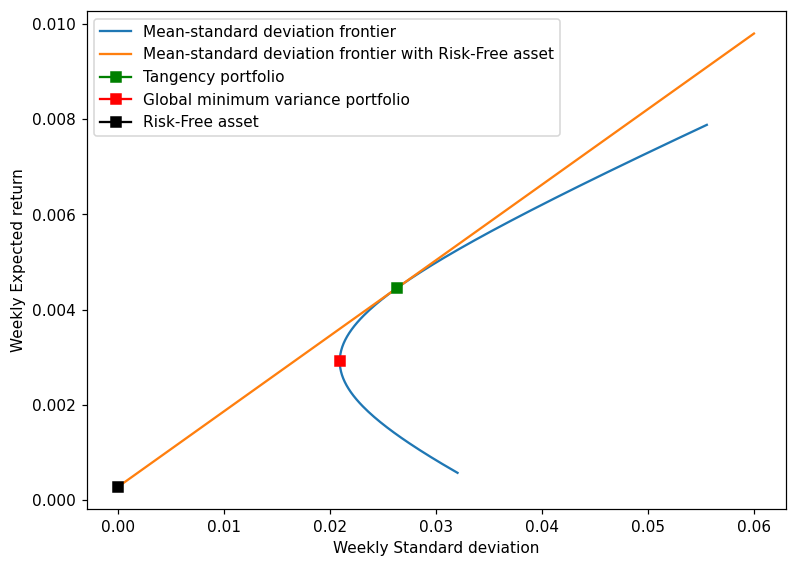

In [39]:
#Question d 
#if we introduce a risk free asset we have the following results obtained using the formulas on slides
#we know from the theory, two fund theorem, that the MVE investors hold a combination of the tangency portfolio and the risk free asset
#depending on their risk aversion

#setting graphical parameters
f = plt.figure()
f.set_figwidth(8.2)
f.set_figheight(6)

#first thing we do is to calculate the tangency portfolio
mu = np.array(data.mean())
#this is the same c defined at slide 43
c =  (np.dot(np.linalg.inv(Sigma), (mu - risk_free ))).sum()

#we have the weight on the first asset of the tangency portfolio
#we save as w_tan the weight on AAPL, the weight on PG will be (1-w_tan)
w_tan = ((1/c) * np.dot(np.linalg.inv(Sigma), (mu - risk_free )))[0]

#mean and variance of tangency portfolio
y_tan, x_tan = frontier(data.mean(), Sigma, w_tan)
sr_tan = (y_tan -risk_free)/x_tan


#thanks to the two fund theorem then we can see the e mean-standard deviation frontier as the combination of
#the tangency and the risk free, and therefore it is a line, where the slope corresponds to the SR of the tangency portolio
def tan_line(x):
    return risk_free + sr_tan * x

sigma_for_tan = np.linspace(0, 0.06,10)

#plot the line and also the frontier 
plt.plot(x,y, label="Mean-standard deviation frontier")
plt.plot(sigma_for_tan, tan_line(sigma_for_tan), label= "Mean-standard deviation frontier with Risk-Free asset")
plt.plot(x_tan, y_tan, color="green", marker="s", label="Tangency portfolio")
plt.plot(x_min, y_min, color="red", marker="s", label="Global minimum variance portfolio")
plt.plot(0,risk_free, color="black", marker="s", label="Risk-Free asset")
plt.xlabel("Weekly Standard deviation")
plt.ylabel("Weekly Expected return")
plt.legend()
plt.show()





In [8]:
#Question e
#now we have a desired return 
desired_annual = 0.5
desired_weekly = desired_annual/52

#we can get the weight to put on the risk free asset to get the desired return 
#where y_tan is the mean of the tangency portfolio 

w_rf = ( desired_weekly - y_tan )/(risk_free - y_tan)

#weight on apple and on PG
w_AAPL = (1 - w_rf)*w_tan
w_PG = (1 - w_rf)*(1-w_tan)

print("Millions invested in the risk free", w_rf.item()*10)
print("Millions invested in AAPL", w_AAPL.item()*10)
print("Millions invested in PG", w_PG.item()*10)
print("Total millions invested", (w_AAPL+ w_PG +w_rf).item()*10)



Millions invested in the risk free -12.344405366374328
Millions invested in AAPL 12.60054523050118
Millions invested in PG 9.74386013587315
Total millions invested 10.0


In [44]:
#Question f and g
#we need to find the implied risk adversion coefficient
a = (y_tan - risk_free)*c / (desired_weekly-risk_free)
print("Implied coefficient of risk adversion ", round(a.item(),6))


#The volatility comes from the risky part 
std_desired = (1-w_rf) * x_tan 
print(f"Annual standard deviation of desired portfolio   {round(std_desired.item()* 100*np.sqrt(52),5)}%")
#we consider the volatility of the portfolio in millions 
print(f"Annual standard deviation of desired portfolio in millions   {round(std_desired.item()* 10*np.sqrt(52),5)}")

#we report also the sharpe ratios 
sr_weekly = (desired_weekly - risk_free)/std_desired
sr_annual = (0.50 - risk_free*52)/(std_desired * np.sqrt(52))
print("Annual Sharpe Ratio  ",sr_annual.item())
print("Weekly Sharpe Ratio  ", sr_weekly.item())


Implied coefficient of risk adversion  2.693766
Annual standard deviation of desired portfolio   42.43175%
Annual standard deviation of desired portfolio in millions   4.24317
Annual Sharpe Ratio   1.1430120280453877
Weekly Sharpe Ratio   0.15850724906114344
